In [1]:
# yolov8 on official TACO
# classes are materials

# 1. Preparation
 - import dependencies and download data

In [2]:
mount_drive = True
reduced = True


In [3]:
!nvidia-smi

Sat Feb 18 16:28:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    52W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%capture
%rm -rf /content/*
!pip install ultralytics


In [5]:
import ultralytics

In [6]:
%%capture
!wget https://raw.githubusercontent.com/scikit-multilearn/scikit-multilearn/master/skmultilearn/model_selection/iterative_stratification.py
from iterative_stratification import *
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
from collections import Counter


import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

import shutil
import os
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [7]:
if not mount_drive:
  !gdown 1X3O2v3GIPveq3ylWF6o1qHI5uzbN1vWA # download organized TACO images (TACO itself, 1500 images, without unofficial images)

if mount_drive:
  from google.colab import drive
  drive.mount('/gdrive')
  if not os.path.isfile('/content/rotated2.zip'):
    %cp /gdrive/MyDrive/rotated2_og.zip /content/rotated2.zip
    

Mounted at /gdrive


In [8]:
!unzip -qq ./rotated2.zip 
%mv ./content/yoloTACO ./TACO
# TACO comes with labels, since we'll filter and reorganize these labels, we delete them to avoid duplication
%rm -rf ./TACO/labels

In [9]:
%%capture
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations.json
!wget https://raw.githubusercontent.com/pedropro/TACO/master/data/annotations_unofficial.json

# 2. Data pipeline

## get labels

In [10]:
base_anno = './annotations.json'
unof_anno =  './annotations_unofficial.json'

base_coco_anno = COCO(annotation_file=base_anno)
unof_coco_anno = COCO(annotation_file=unof_anno)

with open(base_anno, 'r') as f:
    base_anno = json.loads(f.read())

with open(unof_anno, 'r') as f:
    unof_anno = json.loads(f.read())   

# get the "id to superid" relationship
supercat_cat_id = [[i['supercategory'],i['name'],i['id']] for i in base_anno['categories']]
id_supercat = {i[2]:i[0] for i in supercat_cat_id}
super_id = {j:i for i,j in enumerate(list(dict.fromkeys([(j) for i,j in enumerate([i['supercategory'] for i in base_anno['categories']])])))}
id_superid = {i:super_id[id_supercat[i]] for i in range(60)}

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


## Reduce label classes

In [11]:
!wget https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv

--2023-02-18 16:30:17--  https://raw.githubusercontent.com/running-man-01/utilities/main/material_key.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1829 (1.8K) [text/plain]
Saving to: ‘material_key.csv’

material_key.csv    100%[===================>]   1.79K  --.-KB/s    in 0s      

2023-02-18 16:30:17 (38.7 MB/s) - ‘material_key.csv’ saved [1829/1829]



In [12]:
mkey = pd.read_csv('./material_key.csv')
mkey_dict = {i:j for i,j in zip(mkey.cat_id, mkey.m_id)}
mkey[:6]

,cat_id,category,m_id,material,illustration,illustration_
0,0,Aluminium foil,0,metal,metal,0.0
1,1,Battery,0,metal,plastic,1.0
2,2,Aluminium blister pack,0,metal,glass,2.0
3,3,Carded blister pack,1,plastic,paper,3.0
4,4,Other plastic bottle,1,plastic,other,4.0
5,5,Clear plastic bottle,1,plastic,NaN,NaN


## filter and reorder labels

In [13]:
# %cd ..

In [14]:
bbox_thold =  50*50 # threshold of bbox under which bbox will be discarded being too small
                  # threshold value = width*height, e.g. 40*40 = 1600 pixels


dst = "./TACO"

%rm -rf ./TACO/labels #reset labels
!mkdir ./TACO/labels

base_imgs = base_anno['images']


counter = 0
skip_counter = 0
obj_counter=0
for img in tqdm(base_imgs):
  height = img['height']
  width = img['width']

  # reorganize images
  img_id = img['id']

  annotation_ids = base_coco_anno.getAnnIds(img_id)

  if len(annotation_ids) == 0:
    continue

  with open(dst+'/labels/'+str(img_id)+'.txt', mode='w') as fp:
    annotations = base_coco_anno.loadAnns(annotation_ids)
    lines = ''
    for annotation in annotations:
      obj_counter+=1
      class_ = copy.copy(annotation['category_id'])
      class_ = mkey_dict[class_]
      box = copy.copy(annotation['bbox'])

      # some annotations have basically no width / height (extremely small), skip them
      if box[2] * box[3] < bbox_thold:
        skip_counter+=1 # count number of skippped bbox for being too small

        # uncomment below line to see which images have bbox skipped
        #print('bbox too small, skipped. skipped bbox is in image ID:'+ str(img_id))
        continue
      # top_x,top_y,width,height ----> cen_x,cen_y,width,height
      # standardize to 0-1
      box[0] = round((box[0] + box[2] / 2) / width, 6)
      box[1] = round((box[1] + box[3] / 2) / height, 6)
      box[2] = round(box[2] / width, 6)
      box[3] = round(box[3] / height, 6)
      # line: super_id x_center y_center width height
      lines += str(class_)
      for i in box:
        lines += ' ' + str(i)
      lines = lines+ '\n'
    fp.writelines(lines)

  counter+=1


print('\n\nNumber of skipped bbox, number of bbox in all:')
skip_counter,obj_counter

100%|██████████| 1500/1500 [00:00<00:00, 10553.44it/s]



Number of skipped bbox, number of bbox in all:


(876, 4784)

## train test split

In [15]:
nr_imgs=None
for root, dirnames, filenames in os.walk('./TACO/labels/'):
  nr_imgs = len(filenames)
  break
print('Number of all images:\n'+str(nr_imgs))

nr_class = len(set(mkey_dict.values()))


Number of all images:
1500


In [16]:
xy = {}
for i in tqdm(range(nr_imgs)):
  try: 
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    y=i
    xy[y]=x

  except: 
    print('\nimage id number '+str(i)+' skipped due to no label found')
    pass
X = pd.DataFrame.from_dict(xy, orient='index')

y = xy.keys()
one_hot_y = pd.get_dummies(y)

## train test split
'''
train: images/train
val: images/val
test: images/test
'''

np.random.seed(1) # sk-multilearn is based on sk, sk uses np random state. 
                  # so, setting np random seed will clamp the results of iterative_train_test_split

X_train, y_train, X_temp, y_temp = iterative_train_test_split(X.values, one_hot_y.values, test_size = 0.5)
X_train1, y_train1, X_val, y_val = iterative_train_test_split(X_temp, y_temp, test_size = 0.5)
X_val, y_val,X_test,y_test = iterative_train_test_split(X_val, y_val, test_size = 0.5)

# ISSUE: in this environment, any test_size!= 0.5 results in nothing in testing set. 
# therefore train/val/test split is roughly .75, .125, .125

y_train = np.vstack((y_train,y_train1))
train_ids,val_ids,test_ids = pd.DataFrame(y_train,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_val,columns = y).idxmax(axis=1).tolist(),\
                            pd.DataFrame(y_test,columns = y).idxmax(axis=1).tolist()


100%|██████████| 1500/1500 [00:01<00:00, 758.92it/s]


In [17]:
# check no intersection
print(set(train_ids).intersection(set(val_ids)), set(train_ids).intersection(set(test_ids)), set(val_ids).intersection(set(test_ids)))

# check total number of img_ids
print(len(set(train_ids).union(set(val_ids)).union(set(test_ids))))

set() set() set()
1500


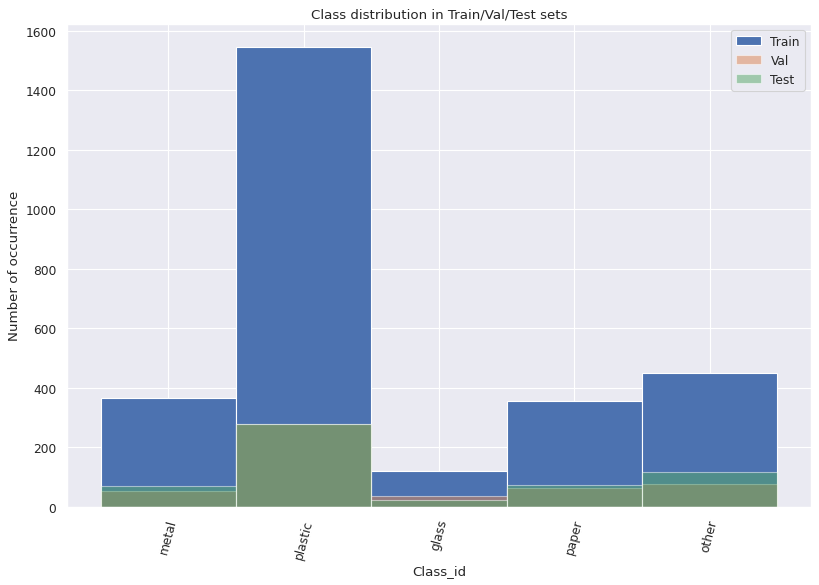

In [18]:
# Visual check of train-test split

def list_add(list1, list2): 
  return [sum(x) for x in zip(list1, list2)]

def vis(img_id_list):
  vis=[0]*nr_class
  for i in img_id_list:
    X = open('./TACO/labels/'+str(i)+'.txt','r')
    lines = X.readlines()
    classes = [int(line.split()[0]) for line in lines]
    x_ = pd.DataFrame([Counter(classes)],columns=[*range(nr_class)]).fillna(0).astype(int).iloc[[0]].squeeze().tolist()
    vis=list_add(vis,x_)
  return vis

from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

plt.bar([*range(nr_class)],vis(train_ids), width = 1, label = 'Train')
plt.bar([*range(nr_class)],vis(val_ids), width = 1, label = 'Val',alpha = 0.5)
plt.bar([*range(nr_class)],vis(test_ids), width = 1, label = 'Test',alpha = 0.5)

plt.xticks([0,1,2,3,4],['metal','plastic','glass','paper','other'],rotation = 75)
plt.xlabel("Class_id")
plt.ylabel("Number of occurrence")
plt.title("Class distribution in Train/Val/Test sets")
plt.legend()
plt.show()

In [19]:
%%capture

def move_helper(ids, desti):
  for id in ids:
    img_name = os.path.join( './TACO/images', str(id)+'.jpg' )
    lbl_name = os.path.join( './TACO/labels', str(id)+'.txt' )
    print(img_name)
    if os.path.isfile(img_name):
        shutil.copy( img_name, './TACO/images/'+desti)
        shutil.copy( lbl_name, './TACO/labels/'+desti)
    else :
        print('file does not exist', img_name)

!mkdir TACO/images/{train,val,test}
!mkdir TACO/labels/{train,val,test}

move_helper(test_ids,'test')
move_helper(train_ids,'train')
move_helper(val_ids,'val')


# 3. Parameters

In [20]:
#@title data yml

with open('/content/TACO.yaml', mode='w') as fp:
  lines = '''path: ../TACO  # dataset root dir
train: images/train  # train images 
val: images/val  # val images 
test: images/test # test images (optional)

# Classes
names:
  0: metal
  1: plastic
  2: glass
  3: paper
  4: other
'''
  fp.writelines(lines)

# 4. Training

In [22]:
model = None

In [23]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)

# Train the model
model.train(data="/content/TACO.yaml", epochs=200, imgsz=640, batch = 32)


# Use the model
#results = model.train(data="coco128.yaml", epochs=3)  # train the model
#results = model.val()  # evaluate model performance on the validation set
#results = model("https://ultralytics.com/images/bus.jpg")  # predict on an image
#success = model.export(format="onnx")  # export the model to ONNX format

  0%|          | 0.00/131M [00:00<?, ?B/s]

Ultralytics YOLOv8.0.40 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/TACO.yaml, epochs=200, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.Conv                  [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.Conv                  [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.C2f                   [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.Conv                  [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.C2f                   [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.Conv                  [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.C2f                   [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

KeyboardInterrupt: ignored

# 5. Validation


In [45]:
model = YOLO("/content/runs/detect/train/weights/best.pt")  # load a custom model

# Validate the model
metrics = model.val(data="/content/TACO.yaml")

Ultralytics YOLOv8.0.40 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (NVIDIA A100-SXM4-40GB, 40536MiB)
Model summary (fused): 268 layers, 68128383 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/TACO/labels/val.cache... 198 images, 1 backgrounds, 0 corrupt: 100%|██████████| 198/198 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                   all        198        505      0.304      0.289      0.262      0.214
                 metal        198         52      0.371      0.404      0.354      0.319
               plastic        198        277      0.534      0.502      0.482      0.372
                 glass        198         35          0          0    0.00212    0.00148
                 paper        198         63       0.33      0.333      0.324       0.28
                 other        198         78      0.287      0.205      0.146     0.0978
Speed: 0.5ms pre-p

## Example detections

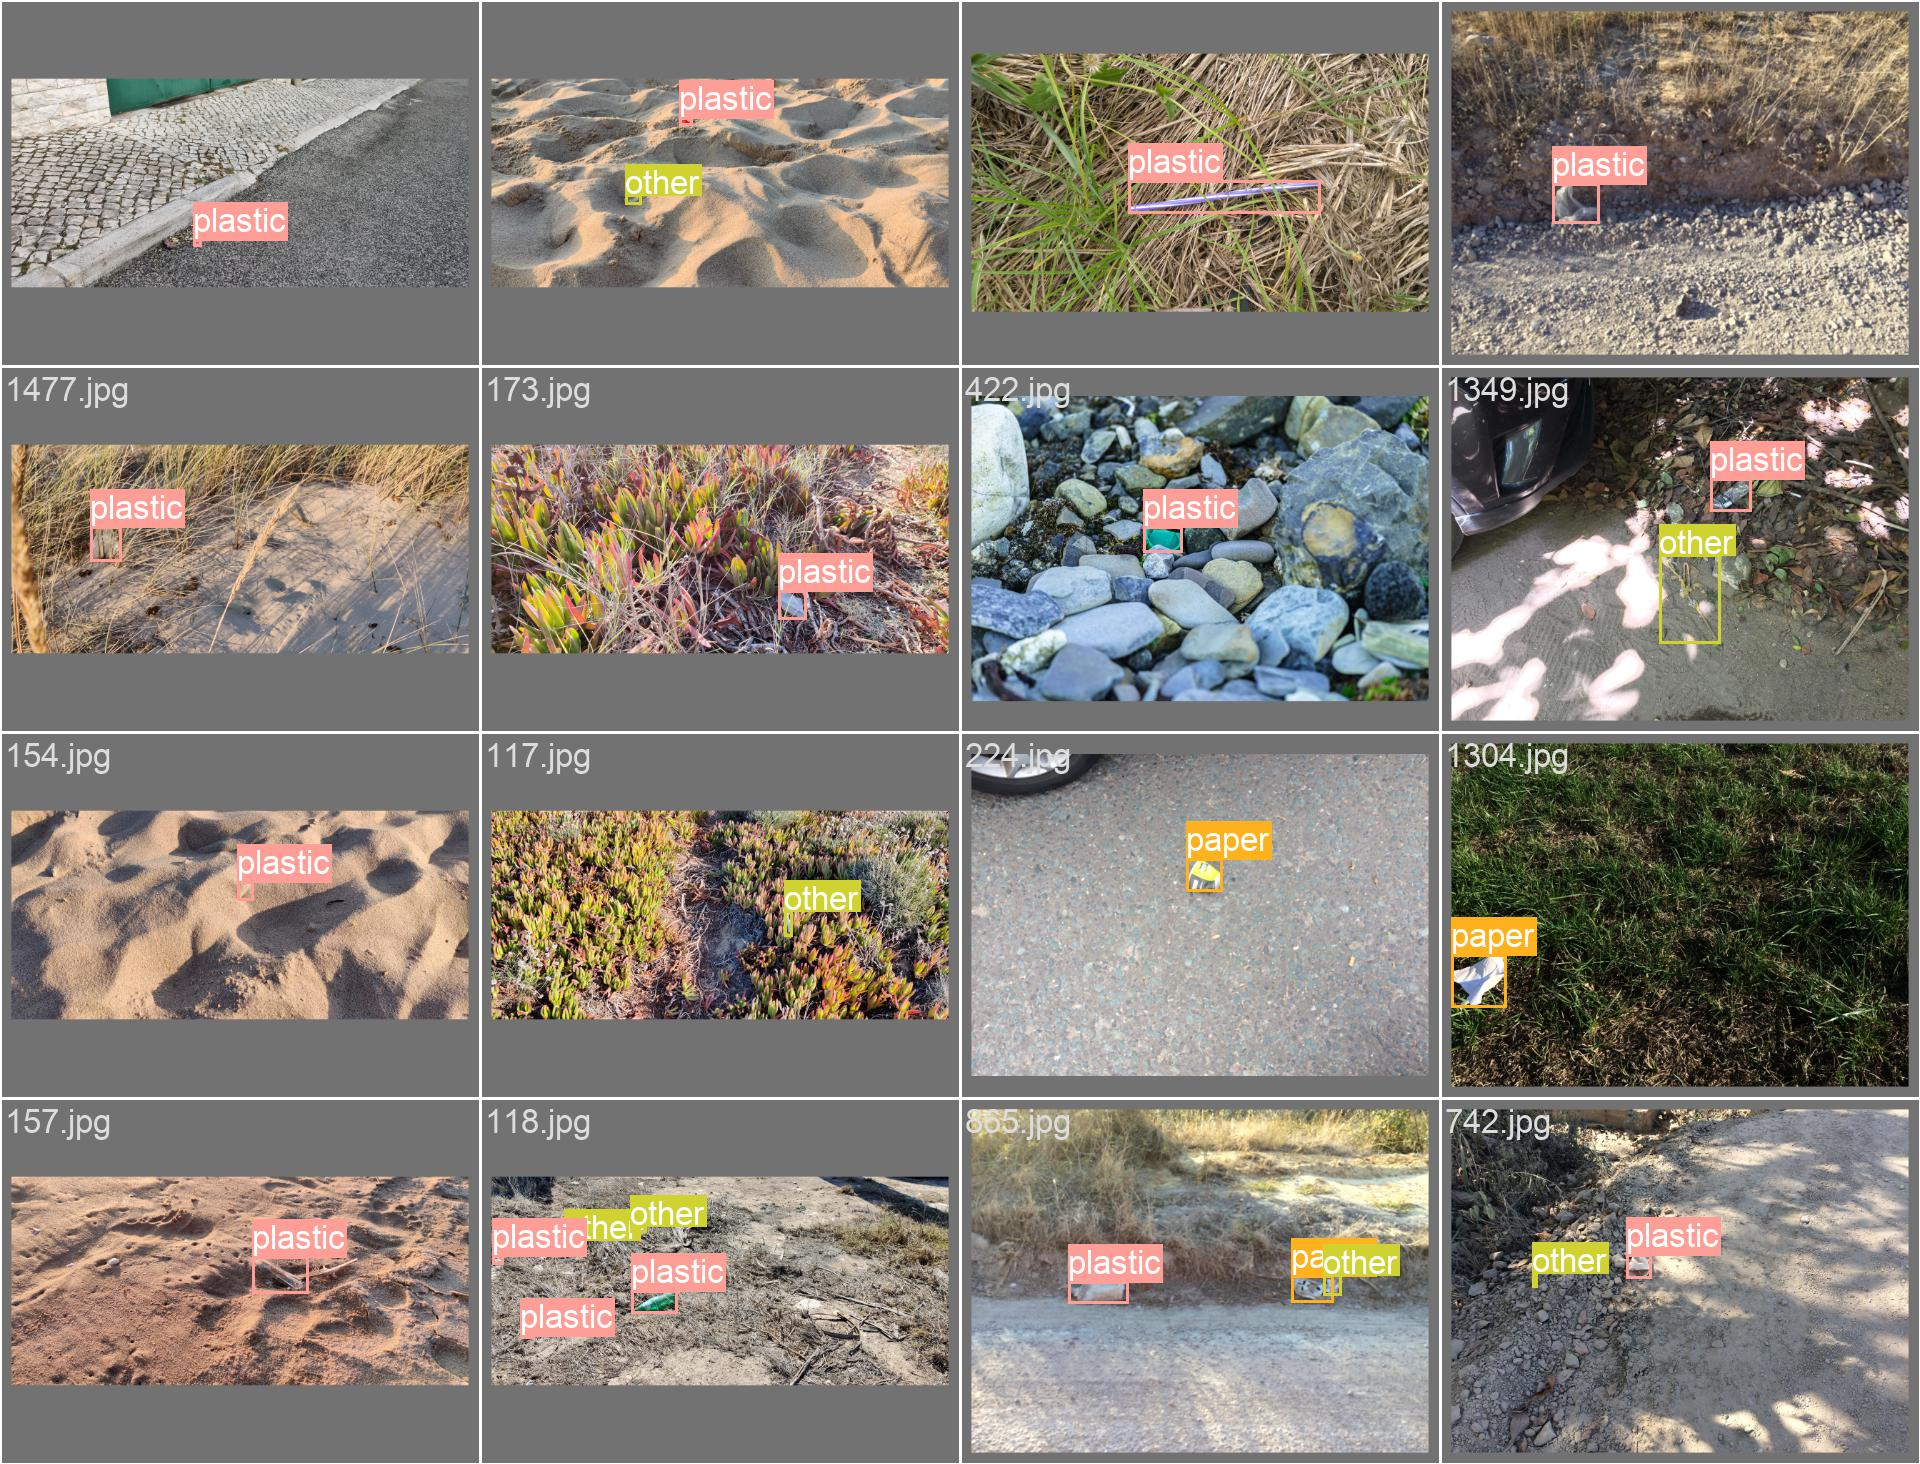

In [46]:
from IPython import display
display.Image("/content/runs/detect/val/val_batch0_labels.jpg")


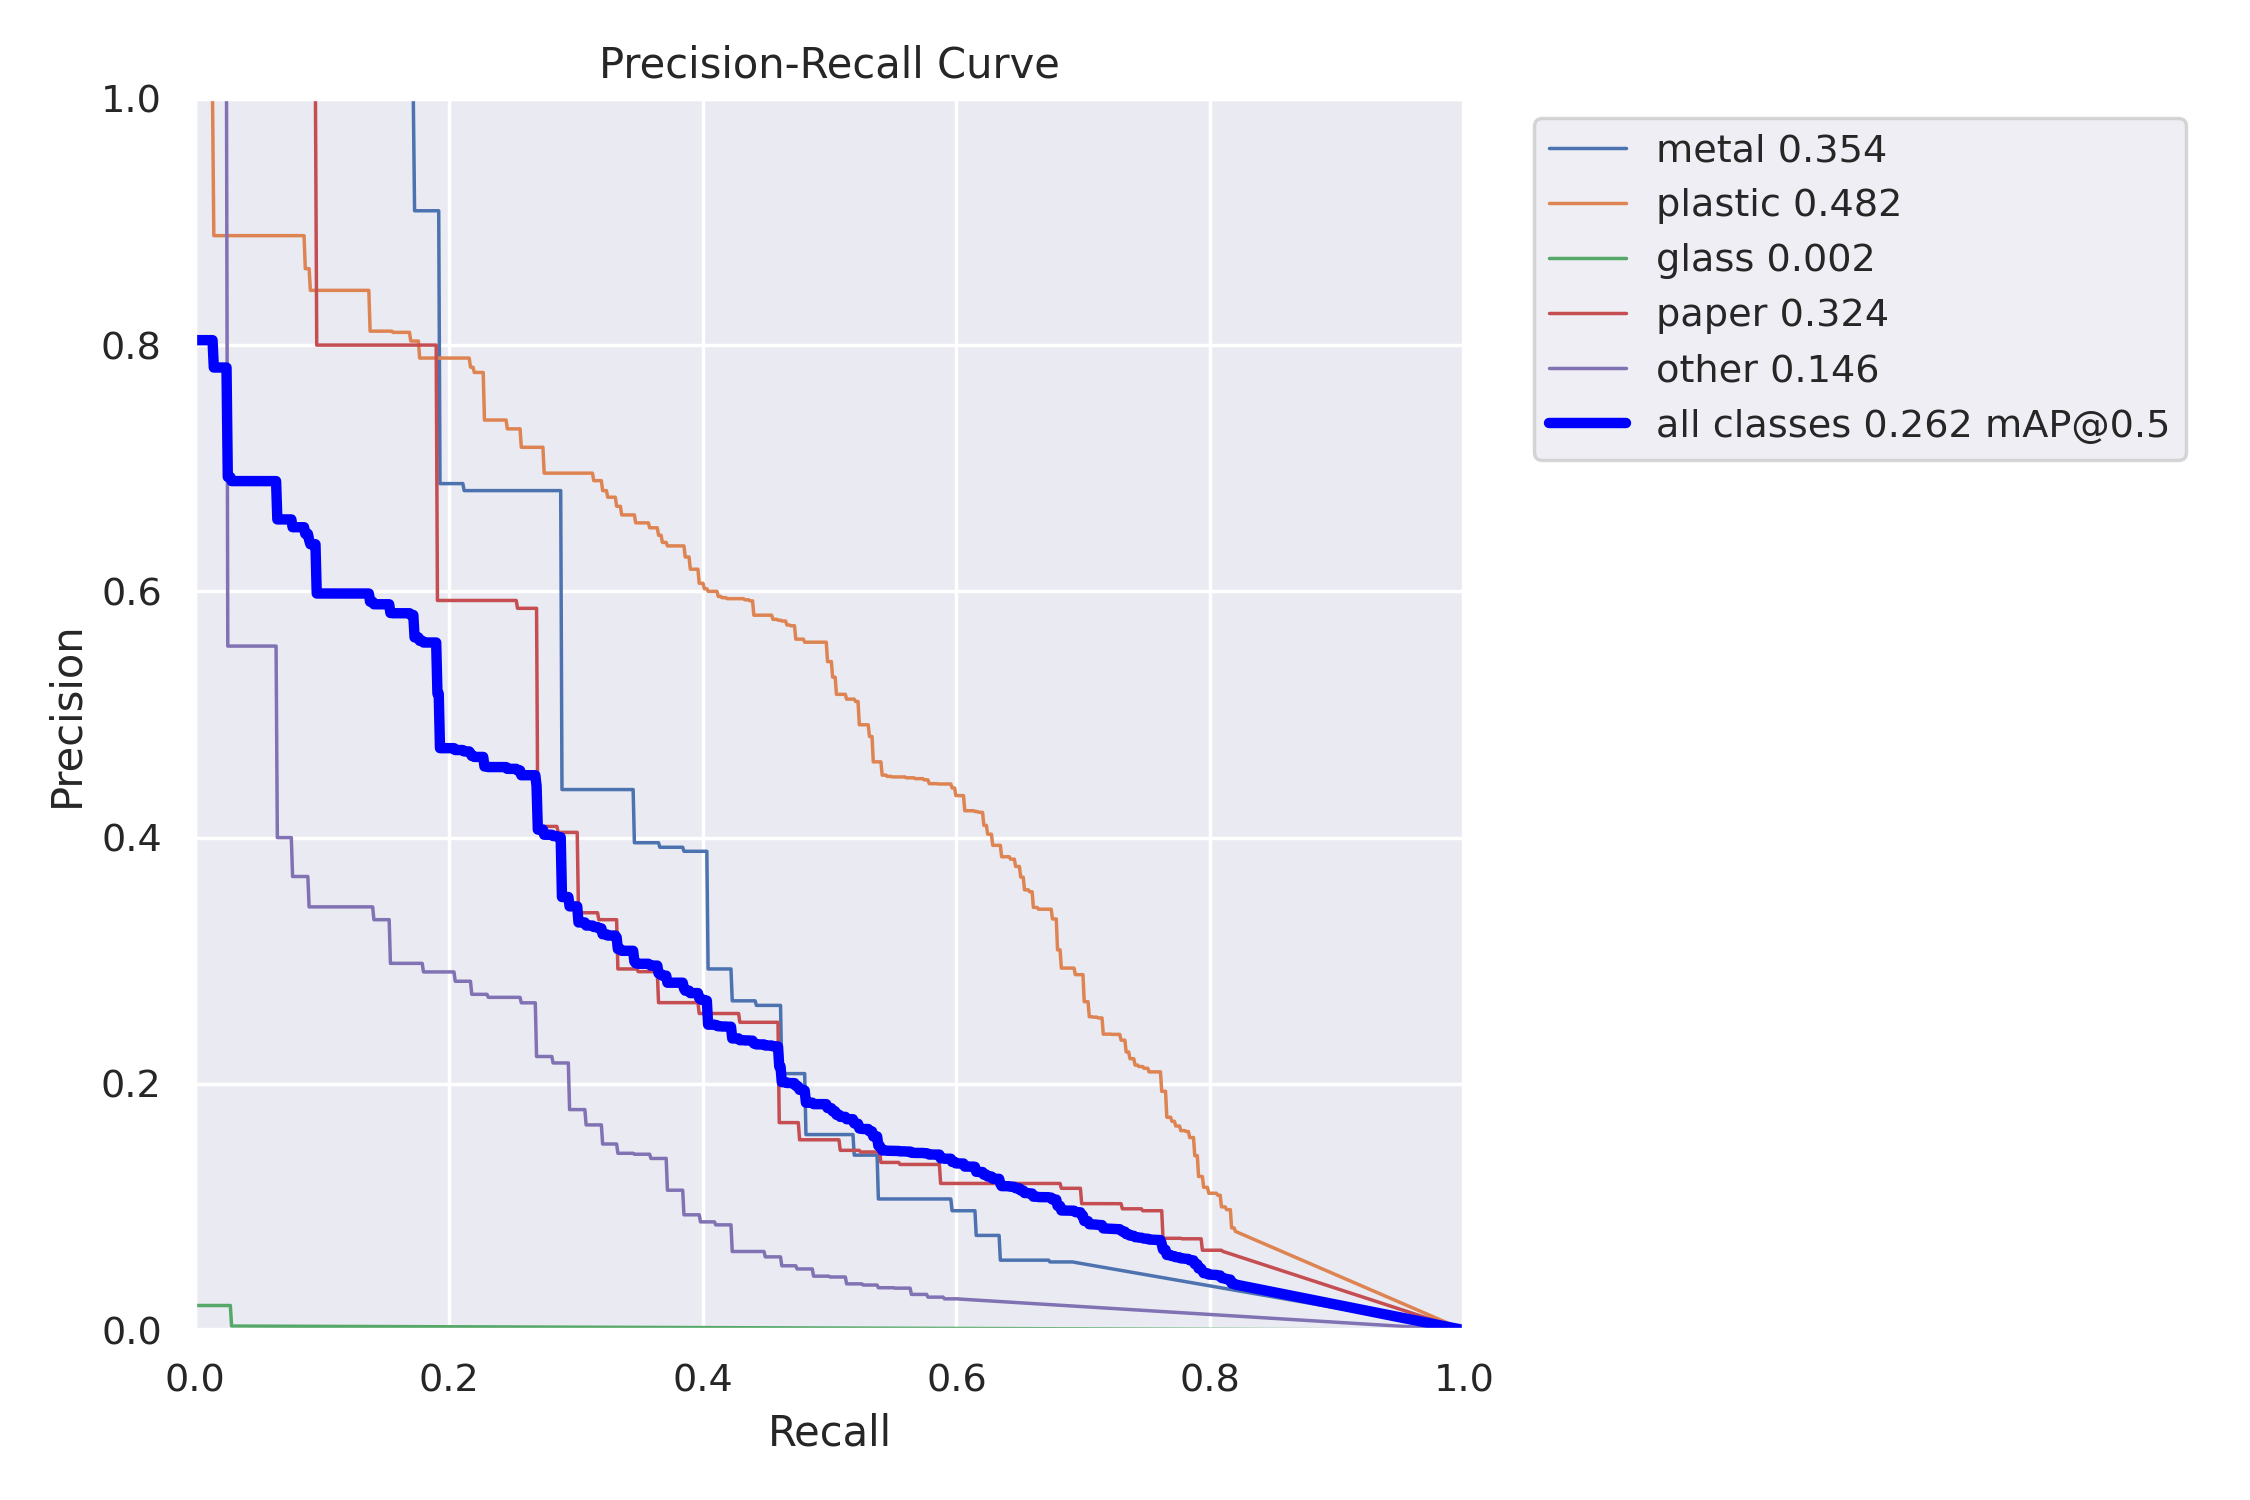

In [47]:
display.Image("/content/runs/detect/val/PR_curve.png")

In [49]:
%%bash
rm -rf /gdrive/MyDrive/yolo_8_m/
mkdir /gdrive/MyDrive/yolo_8_m/
cp -r /content/runs/detect/* /gdrive/MyDrive/yolo_8_m/
